# Graph v2.1

This graph is similar to graph v1.6. Each node represents a spectra and if two nodes have a peak in the same grid-slot, we say they have a similar peak which we assume means they share some property. As a result of this the two spectra are linked. How this graph differs from v1.6 is that there is no relationship weight in this graph. Instead, a node weight or feature is made. This feature is simply a list of float values. These float values are the absobance values in order for each spectra. Since each spectra has the same WaveNumber values, we can take the Absobance values as a vector and use that as a node weight. This is perticularly helpful in the Fast RP embedding algoritm as some of its parameters are only customisable when a node property is present. 

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [3]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [4]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [5]:
sample = df[df['SpecID'] == "210407-1-01"]

Divided by 400 as that is rougly the range before the peaks were scaled

In [6]:
peak_index, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42/400, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

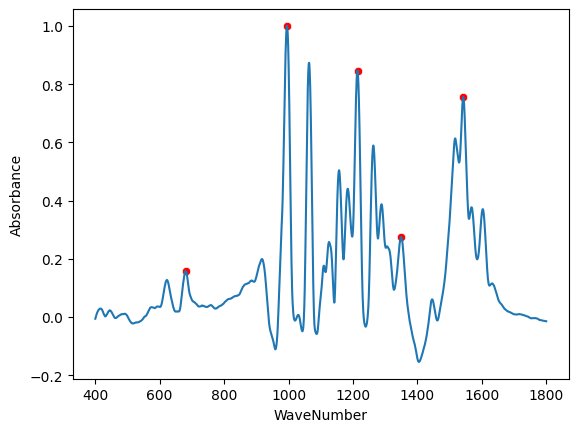

In [7]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[peak_index], x="WaveNumber", y="Absorbance", color="red")

In [8]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,0.203556
1,201210-1-00,294,400.91116,201210-1,Normal,0.203010
2,201210-1-00,295,401.59454,201210-1,Normal,0.202464
3,201210-1-00,296,402.27789,201210-1,Normal,0.201917
4,201210-1-00,297,402.96127,201210-1,Normal,0.201370
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-0.078901
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-0.074710
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-0.070333
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-0.065772


In [9]:
peaks = []
widths = []
prominences = []
areas = []

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42/400, width=6)
    # peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

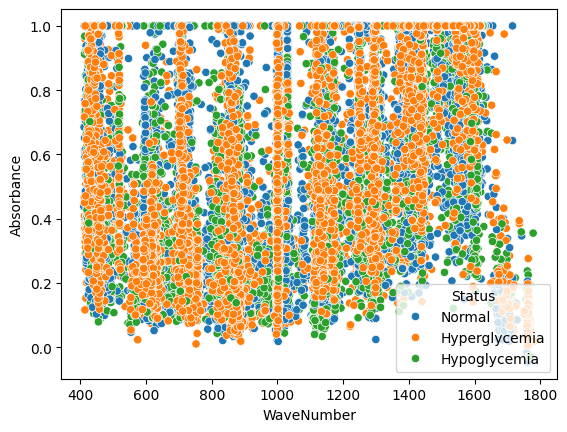

In [10]:
sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue="Status")

In [11]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [12]:
# Set the size of the grid slots
WaveNumber_slot_size = 8
Absorbance_slot_size = 0.01

peaks_df['GridSlot'] = peaks_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

C:\Users\stang\AppData\Local\Temp\ipykernel_6944\1987900641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['GridSlot'] = peaks_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [13]:
peaks_df['GridSlot'].nunique()

6972

In [14]:
peaks_df['Node_ID'] = peaks_df.index

C:\Users\stang\AppData\Local\Temp\ipykernel_6944\3561900980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Node_ID'] = peaks_df.index


In [15]:
peaks_df.drop(columns=['Seq', 'SurID'], inplace=True)

C:\Users\stang\AppData\Local\Temp\ipykernel_6944\4174181308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df.drop(columns=['Seq', 'SurID'], inplace=True)


In [16]:
from itertools import combinations

# Find combinations of SpecID for each GridSlot
grouped = peaks_df.groupby('GridSlot')['SpecID'].apply(list)

# Create new DataFrame for shared peaks
shared_peaks = []

for spec_ids in grouped:
    for combo in combinations(spec_ids, 2):
        shared_peaks.append({'SpecID1:Start_ID': combo[0], 'SpecID2:END_ID': combo[1]})

shared_peaks_df = pd.DataFrame(shared_peaks)

In [17]:
peaks_df['SpecID'].nunique()

3045

In [18]:
shared_peaks_df['SIMILAR:TYPE'] = 'SIMILAR'

In [19]:
# Flatten the SpecID values from both columns of shared_peaks_df into a single set
shared_spec_ids = set(shared_peaks_df['SpecID1:Start_ID'].tolist() + shared_peaks_df['SpecID2:END_ID'].tolist())

# Get the set of SpecID values from peaks_df
original_spec_ids = set(peaks_df['SpecID'].tolist())

# Find the difference between the sets
missing_spec_ids = original_spec_ids - shared_spec_ids

# Count how many values are missing
missing_count = len(missing_spec_ids)

print(f"Number of SpecID values from peaks_df missing in shared_peaks_df: {missing_count}")
if missing_count > 0:
    print("Missing SpecID values:", missing_spec_ids)


Number of SpecID values from peaks_df missing in shared_peaks_df: 0


In [20]:
shared_peaks_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [22]:
shared_peaks_df

,SpecID1:Start_ID,SpecID2:END_ID,SIMILAR:TYPE
0,210217-1-37,210401-1-24,SIMILAR
1,210303-1-47,210325-1-34,SIMILAR
2,210304-1-08,210311-2-41,SIMILAR
3,210311-1-47,210519-3-00,SIMILAR
4,210120-1-05,210407-1-47,SIMILAR
...,...,...,...
187046,210419-2-37,210428-1-16,SIMILAR
187047,210120-1-40,210120-1-42,SIMILAR
187048,210120-1-40,210211-1-27,SIMILAR
187049,210120-1-42,210211-1-27,SIMILAR


In [21]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,0.203556
1,201210-1-00,294,400.91116,201210-1,Normal,0.203010
2,201210-1-00,295,401.59454,201210-1,Normal,0.202464
3,201210-1-00,296,402.27789,201210-1,Normal,0.201917
4,201210-1-00,297,402.96127,201210-1,Normal,0.201370
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,-0.078901
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,-0.074710
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,-0.070333
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,-0.065772


In [31]:
nodes_df = df.groupby('SpecID')['Absorbance'].agg(list).reset_index()

In [32]:
nodes_df

,SpecID,Absorbance
0,201210-1-00,"[0.20355619742251038, 0.20301040674308493, 0.2..."
1,201210-1-01,"[0.207050332939185, 0.2125951769601587, 0.2179..."
2,201210-1-02,"[0.09347296491641463, 0.0925972290053014, 0.09..."
3,201210-1-03,"[0.24292043144744754, 0.2407942046007612, 0.23..."
4,201210-1-04,"[0.42455923142609203, 0.41513186334810404, 0.4..."
...,...,...
3040,210526-3-45,"[-0.009309279976126145, -0.009208953682924221,..."
3041,210526-3-46,"[0.008168459642031115, -0.007447995366759516, ..."
3042,210526-3-47,"[0.0940016325721522, 0.08309032970249698, 0.07..."
3043,210526-3-48,"[-0.05745559637613418, -0.061159239622681855, ..."


In [33]:
nodes_df['Absorbance'] = [", ".join(map(str, item)) for item in nodes_df['Absorbance']]

In [43]:
nodes_df.rename(columns={'SpecID':'SpecID:ID'}, inplace=True)
nodes_df[':LABEL'] = 'Spectra'

In [45]:
nodes_df.to_csv(f"{neo4j_directory}/import/nodes.csv", index=False)

In [37]:
status_df = df.groupby('SpecID')['Status'].first().reset_index()

In [38]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [58]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.12.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 18.83GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 16.25GiB
  High parallel IO: true


Import starting 2024-03-24 09:49:54.808+0000
  Estimated number of nodes: 3.07 k
  Estimated number of node properties: 6.13 k
  Estimated number of relationships: 187.05 k
  Estimated number of relationship properties: 0.00 
  Estimated disk space usage: 139.5MiB
  Estimated required memory usage: 510.0MiB

(1/4) Node import 2024-03-24 09:49:54.919+0000


In [ ]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Run and connect to the Neo4j Database

In [69]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

In [60]:
def to_float_list(tx):
    query = """
    MATCH (a:Spectra)
    SET a.Absorbance = [r IN split(a.Absorbance, ",") | toFloat(r)]
    """
    result = tx.run(query)

In [61]:
with driver.session() as session:
    session.execute_write(to_float_list)

**First create the gds Graph Projection**

In [89]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      'Spectra',
      {
        SIMILAR: {
          orientation: 'UNDIRECTED'
        }
      },
      {
        nodeProperties: 'Absorbance'
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Define the graph algorithms.

In [63]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [64]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [65]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [73]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [74]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph')
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [75]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph')
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [76]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph')
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["Community"]) for record in results]

In [138]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        {randomSeed:1234,
         embeddingDimension: 32,
         featureProperties:['Absorbance'],
         propertyRatio:1
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name,  embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [79]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [80]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'Louvain'])

In [81]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, label_propagation_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on='name', how='left')

In [82]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,LabelPropagation,Leiden,Louvain
0,210325-1-35,1.927430,346.0,0.060072,0.429127,1852,14,1281
1,210224-1-00,1.860635,340.0,0.062717,0.423103,1852,14,1281
2,210225-1-03,1.833905,335.0,0.060525,0.418953,1852,14,1281
3,210224-1-03,1.808742,342.0,0.064356,0.422723,1852,14,1281
4,210224-1-05,1.783265,337.0,0.063634,0.418642,1852,14,1281
...,...,...,...,...,...,...,...,...
3040,210519-2-07,0.192459,5.0,0.000227,0.154573,27,3,104
3041,210310-2-42,0.184562,5.0,0.000463,0.154369,27,1,1565
3042,210303-1-45,0.179604,3.0,0.000009,0.152832,27,8,104
3043,201210-1-02,0.172629,1.0,0.000001,0.151009,27,1,942


In [139]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31
0,201210-1-00,-0.008803,0.052226,-0.507786,0.681849,-0.245299,0.310829,-0.698550,0.113438,-0.301049,...,-0.092076,-0.470549,-0.722455,0.194262,0.484546,0.207516,0.227330,0.165947,-0.403396,-0.376031
1,201210-1-01,0.052756,0.165620,-0.380929,0.723714,-0.190779,0.338203,-0.831205,0.173126,-0.376685,...,-0.124172,-0.402030,-0.688201,0.229447,0.452933,0.343043,0.214734,0.078448,-0.241718,-0.197100
2,201210-1-02,-0.018999,0.129054,-0.496553,0.690716,-0.249969,0.344459,-0.663694,0.156035,-0.293827,...,-0.097981,-0.391809,-0.666870,0.183822,0.483265,0.199337,0.218036,0.232252,-0.338346,-0.303445
3,201210-1-03,-0.014822,0.142349,-0.464478,0.744533,-0.116548,0.437580,-0.780193,0.119516,-0.360275,...,-0.137205,-0.335111,-0.645932,0.103032,0.507072,0.235306,0.150089,0.107562,-0.156758,-0.162222
4,201210-1-04,0.037842,0.156607,-0.399652,0.739458,-0.190136,0.366624,-0.788381,0.171270,-0.368536,...,-0.101482,-0.394538,-0.688639,0.192223,0.470646,0.294676,0.216255,0.109715,-0.249066,-0.201309


Delete the projection

In [88]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [67]:
close_driver()

In [140]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="SpecID", right_on="SpecID", how="inner")

In [100]:
graph_df = pd.merge(df, status_df, left_on="SpecID", right_on="SpecID", how="inner")

In [101]:
graph_df

,SpecID,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,LabelPropagation,Leiden,Louvain,Status
0,210325-1-35,1.927430,346.0,0.060072,0.429127,1852,14,1281,Normal
1,210224-1-00,1.860635,340.0,0.062717,0.423103,1852,14,1281,Hypoglycemia
2,210225-1-03,1.833905,335.0,0.060525,0.418953,1852,14,1281,Hypoglycemia
3,210224-1-03,1.808742,342.0,0.064356,0.422723,1852,14,1281,Hypoglycemia
4,210224-1-05,1.783265,337.0,0.063634,0.418642,1852,14,1281,Hypoglycemia
...,...,...,...,...,...,...,...,...,...
3040,210519-2-07,0.192459,5.0,0.000227,0.154573,27,3,104,Hyperglycemia
3041,210310-2-42,0.184562,5.0,0.000463,0.154369,27,1,1565,Normal
3042,210303-1-45,0.179604,3.0,0.000009,0.152832,27,8,104,Normal
3043,201210-1-02,0.172629,1.0,0.000001,0.151009,27,1,942,Normal


In [102]:
def modeler(k_folds=5, model='linear', show_matrix=True):

    acc_scores = []

    # Drop the SpecID column
    X = graph_df.drop(columns=['SpecID', 'Status'])

    # Target variable
    y = graph_df['Status']

    for i in range(0, k_folds):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        clf = svm.SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)        
        
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    # if show_matrix:
    #     matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
    #     plt.show(matrix)
    #     plt.show()
        
    return

In [103]:
modeler()

NameError: name 'train_test_split' is not defined

In [104]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Drop the SpecID column
X = graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = graph_df['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)


Random Forest Accuracy: 0.4630541871921182
Extra Trees Accuracy: 0.458128078817734


In [105]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [106]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [107]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.4630541871921182


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.45      0.42      0.43       192
 Hypoglycemia       0.46      0.47      0.47       210
       Normal       0.48      0.50      0.49       207

     accuracy                           0.46       609
    macro avg       0.46      0.46      0.46       609
 weighted avg       0.46      0.46      0.46       609


Confusion Matrix:
[[ 81  55  56]
 [ 55  98  57]
 [ 46  58 103]]


In [108]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.458128078817734


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.43      0.42      0.42       192
 Hypoglycemia       0.47      0.45      0.46       210
       Normal       0.47      0.50      0.49       207

     accuracy                           0.46       609
    macro avg       0.46      0.46      0.46       609
 weighted avg       0.46      0.46      0.46       609


Confusion Matrix:
[[ 80  55  57]
 [ 55  95  60]
 [ 51  52 104]]


In [112]:
get_feature_importances(rf_model, X)

,Feature,Importance
155,embedding_155,0.007408
28,embedding_28,0.007299
207,embedding_207,0.006913
167,embedding_167,0.006902
12,embedding_12,0.006086
238,embedding_238,0.006045
92,embedding_92,0.005883
62,embedding_62,0.005817
20,embedding_20,0.005804
162,embedding_162,0.005792


In [113]:
get_feature_importances(et_model, X)

,Feature,Importance
250,embedding_250,0.005519
91,embedding_91,0.005421
49,embedding_49,0.005345
155,embedding_155,0.005314
169,embedding_169,0.005297
252,embedding_252,0.005185
170,embedding_170,0.005165
224,embedding_224,0.005132
20,embedding_20,0.005127
28,embedding_28,0.005019


In [141]:
# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = fast_graph_df['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.5287356321839081
Extra Trees Accuracy: 0.5139573070607554


Delete the projection

In [ ]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [ ]:
close_driver()